In [352]:
## Packages
# system
import os
import math
# data wrangling
import numpy as np
import pandas as pd
from scipy import stats
from dfply import *
import statistics
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
# models
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, StratifiedKFold, cross_val_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score, make_scorer, accuracy_score, balanced_accuracy_score, f1_score, precision_score, roc_auc_score
## Settings
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 
pd.set_option('display.width', 1000)

## Data Import

In [284]:
df = pd.read_csv('../processed_data/provider_final_new.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df = df.set_index('Provider')
display(df.shape)
df.head(3)

(5410, 46)

,PotentialFraud,DurationMedianIP,DurationMeanIP,DurationMedianOP,DurationMeanOP,Serves,ChronCondsMedian,ChronCondsMean,ChronConsMode,PtAgeMedian,PtAgeMean,NumPtsIP,NumPtsOP,NumStatesIP,NumStatesOP,SharePhysician,MergeAvgClaimReimbursed,NumTopCodeClaim,DupClaimNum_IP,DupClaimRatio_IP,DupClaim_IP,DupClaimStatesNum_IP,DupClaimMultiState_IP,DupClaimProviderNum_IP,DupClaimMultiProvider_IP,DupClaimStartDtNum_IP,DupClaimMultiStartDt_IP,DupClaimNum_OP,DupClaimRatio_OP,DupClaim_OP,DupClaimStatesNum_OP,DupClaimMultiState_OP,DupClaimProviderNum_OP,DupClaimMultiProvider_OP,DupClaimStartDtNum_OP,DupClaimMultiStartDt_OP,AvgDuration,NumOfPt,NumOfClm,ClmPerPt,TotalRev,RevPerPt,ClmNoPhy,ClmAllPhy,ClmNoProc,ClmPerDt
Provider,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PRV51001,No,4.0,5.00000,0.0,0.550000,Both,6.0,5.760000,5.0,79.0,77.880000,5.0,19.0,1.0,1.0,1.0,4185.600000,5.0,0.0,0.000000,no,0.0,no,0.0,no,0.0,no,11.0,0.550000,yes,50.0,yes,422.0,yes,278.0,yes,1.44,24,25,1.04,109980,4582.50,0,2,23,1.09
PRV51003,Yes,4.0,5.16129,0.0,2.357143,Both,7.0,6.674242,6.0,71.0,69.083333,53.0,66.0,3.0,3.0,1.0,4588.409091,25.0,1.0,0.016129,yes,2.0,yes,2.0,yes,2.0,yes,25.0,0.357143,yes,52.0,yes,1351.0,yes,372.0,yes,3.67,117,132,1.13,671956,5743.21,0,4,93,1.19
PRV51004,No,0.0,0.00000,0.0,1.429530,OP,7.0,6.812081,8.0,72.0,71.261745,0.0,138.0,0.0,9.0,1.0,350.134228,5.0,0.0,0.000000,no,0.0,no,0.0,no,0.0,no,72.0,0.483221,yes,52.0,yes,3006.0,yes,375.0,yes,1.43,138,149,1.08,52480,380.29,0,12,149,1.27


## Exclude columns

In [111]:
# display(df.columns[df.columns.str.contains('DupClaim')])
# del_col = ['DupClaim_IP','DupClaim_OP','DupClaimRatio_IP','DupClaimRatio_OP',
#            'DupClaimMultiState_IP','DupClaimMultiState_OP','DupClaimMultiProvider_IP','DupClaimMultiProvider_OP',
#           'DupClaimMultiStartDt_IP','DupClaimMultiStartDt_OP']

In [88]:
# print('before delete cols', df.shape)
# df_num = df.drop(del_col, axis=1)
# print('after delete cols', df_num.shape)

before delete cols (5410, 46)
after delete cols (5410, 36)


## dummy variables

In [285]:
# Make dummies
encode_cols = df[~df.applymap(np.isreal)].dropna(axis=1).columns.to_list()
print(encode_cols)
df[encode_cols[2:]] = df[encode_cols[2:]].applymap(lambda x: 1 if x.lower() == 'yes' else 0)
dummies = pd.get_dummies(df['Serves'],prefix='Serves_',drop_first=True)
df_dum = pd.concat([df.drop('Serves',axis=1),dummies],axis=1)
df_dum.shape

['PotentialFraud', 'Serves', 'DupClaim_IP', 'DupClaimMultiState_IP', 'DupClaimMultiProvider_IP', 'DupClaimMultiStartDt_IP', 'DupClaim_OP', 'DupClaimMultiState_OP', 'DupClaimMultiProvider_OP', 'DupClaimMultiStartDt_OP']


(5410, 47)

In [286]:
# this is for pos_label for precision & recall for gridsearchcv
df_dum['PotentialFraud'] = np.where(df_num_dum['PotentialFraud']=='Yes', 1, 0)
df_dum['PotentialFraud'] = np.where(df_num_dum['PotentialFraud']=='Yes', 1, 0)

In [181]:
# def make_dummy_df(df, cols) :
#     for x in cols:
#         dums = pd.get_dummies(df[x], drop_first=True, prefix=x)
#         df = pd.concat((df, dums), axis=1)
#         df.drop([x], axis=1, inplace=True)
#     return df

In [262]:
# # dummy_list_1 = ['Serves'] # for df_num
# dummy_list_2 = ['Serves','DupClaim_IP','DupClaim_OP','DupClaimRatio_IP','DupClaimRatio_OP',
#            'DupClaimMultiState_IP','DupClaimMultiState_OP','DupClaimMultiProvider_IP','DupClaimMultiProvider_OP',
#           'DupClaimMultiStartDt_IP','DupClaimMultiStartDt_OP'] # for df

In [251]:
# # df_num_dum = make_dummy_df(df_num, dummy_list_1)
# df_dum = make_dummy_df(df, dummy_list_2)
# display(df_dum.shape)
# foo = make_dummy_df(df, encode_cols)
# display(foo.shape)

(5410, 1598)

(5410, 47)

In [187]:
# display(df_dum.head(2))
# display(df_num_dum.head(2))

## split train-test

In [287]:
x = df_dum.drop(['PotentialFraud'], axis = 1)
y = df_dum.PotentialFraud
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=4, stratify=y)

In [288]:
# for flag 1,0
print('ytrain class ave', ytrain.mean())
print('ytest class ave', ytest.mean())

print(x.shape)
print(xtrain.shape)
print(xtest.shape)

ytrain class ave 0.09357670979667283
ytest class ave 0.0933456561922366
(5410, 46)
(4328, 46)
(1082, 46)


## Logistic Regression

In [356]:
# recall of positive - sensitivity; recall of negative - specificity
lr = LogisticRegression(random_state=4, class_weight='balanced') # create fake positive/negative to balance

# lr_params = [{'penalty': ['l1', 'l2'], "C":[0.0001,0.001,0.01,0.1,1,10,100], 'max_iter':[1000]}]
# lr_params = [{'penalty': ['elasticnet'], "C":[0.01, 0.1, 1,10,100],
#              'l1_ratio': [0,0.2,0.4,0.6, 0.8,1], 'solver': ['saga']}]

lr_params = [{'penalty': ['l1', 'l2'], "C":[0.0001,0.001,0.01,0.1,1,10,100], 
              'max_iter':[1000], 'solver':['liblinear']}] # l1=lasso

lr_params = [{'penalty': ['l1'], "C":[0.0001,0.001,0.01,0.1,1,10,100], 
              'max_iter':[1000], 'solver':['liblinear']}, 
             {'penalty': ['l2'], "C":[0.0001,0.001,0.01,0.1,1,10,100], 
              'max_iter':[1000]}] # l1=lasso


kf5 = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)
scores = { 'recall': make_scorer(recall_score, pos_label = 1, average = 'binary'), # average: use binary instead of weighted because already have class_weight = balanced in rf, also it's a binary, weighted is more about multiclass; for evaluation don't want to weighted based on proportion  
          'f1': make_scorer(f1_score, pos_label = 1, average = 'binary'), 
         'precision': make_scorer(precision_score, pos_label = 1, average = 'binary'),
         'accuracy': make_scorer(balanced_accuracy_score),
         'specificity': make_scorer(recall_score, pos_label = 0, average = 'binary'), 
         'roc_auc_score': make_scorer(roc_auc_score, average = 'binary')}

# scores = ['f1_weighted', 'recall', 'precision', 'accuracy']
# lr_grid = GridSearchCV(estimator=lr, param_grid=lr_params, return_train_score=True, 
#                        cv = 5, verbose=2, scoring='recall', n_jobs=-1)

lr_grid = GridSearchCV(estimator=lr, param_grid=lr_params, return_train_score=True, 
                       cv = kf5, verbose=2, scoring=scores, refit=False, n_jobs=-1)

%time lr_grid.fit(xtrain, ytrain)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.0s


CPU times: user 688 ms, sys: 309 ms, total: 997 ms
Wall time: 7.44 s


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    7.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=4, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecat...
             scoring={'accuracy': make_scorer(balanced_accuracy_score),
                      'f1': make_scorer(f1_score, pos_label=1, average=weighted),
                      'precision': make_scorer(precision_score, pos_label=1, average=weighted),
                      'recall': make_scorer(

In [354]:
# best model
# display(lr_grid.best_params_)
# print('lr best validation score', lr_grid.best_score_)
# print('lr best train score', lr_grid.score(xtrain, ytrain))

In [357]:
keys = list(lr_grid.cv_results_.keys())
mean_test = [s for s in keys if 'mean_test' in s]
mean_train = [s for s in keys if 'mean_train' in s]
print(mean_test)
print(mean_train)

['mean_test_recall', 'mean_test_f1', 'mean_test_precision', 'mean_test_accuracy', 'mean_test_specificity', 'mean_test_roc_auc_score']
['mean_train_recall', 'mean_train_f1', 'mean_train_precision', 'mean_train_accuracy', 'mean_train_specificity', 'mean_train_roc_auc_score']


In [358]:
lr_grid_scores = pd.DataFrame({'params': lr_grid.cv_results_['params'], 
              'mean_test_recall': lr_grid.cv_results_['mean_test_recall'],
              'mean_train_recall': lr_grid.cv_results_['mean_train_recall'],
              'mean_test_f1': lr_grid.cv_results_['mean_test_f1'],
              'mean_train_f1': lr_grid.cv_results_['mean_train_f1'],
              'mean_test_precision': lr_grid.cv_results_['mean_test_precision'],
              'mean_train_precision': lr_grid.cv_results_['mean_train_precision'],
              'mean_test_accuracy': lr_grid.cv_results_['mean_test_accuracy'],
              'mean_train_accuracy': lr_grid.cv_results_['mean_train_accuracy'],
              'mean_test_specificity': lr_grid.cv_results_['mean_test_specificity'],
              'mean_train_specificity': lr_grid.cv_results_['mean_train_specificity'] 
             })
lr_grid_scores.to_csv('../output/lr_grid_scores.csv')
lr_grid_scores

,params,mean_test_recall,mean_train_recall,mean_test_f1,mean_train_f1,mean_test_precision,mean_train_precision,mean_test_accuracy,mean_train_accuracy,mean_test_specificity,mean_train_specificity
0,"{'C': 0.0001, 'max_iter': 1000, 'penalty': 'l1...",0.891639,0.892733,0.904752,0.905703,0.930638,0.931501,0.858300,0.861948,0.891639,0.892733
1,"{'C': 0.0001, 'max_iter': 1000, 'penalty': 'l2...",0.887250,0.889961,0.901462,0.903848,0.929675,0.932062,0.856986,0.866231,0.887250,0.889961
2,"{'C': 0.001, 'max_iter': 1000, 'penalty': 'l1'...",0.891869,0.892387,0.905049,0.905546,0.931354,0.931951,0.861749,0.864248,0.891869,0.892387
3,"{'C': 0.001, 'max_iter': 1000, 'penalty': 'l2'...",0.885863,0.889498,0.900356,0.903405,0.929056,0.931492,0.855114,0.864038,0.885863,0.889498
4,"{'C': 0.01, 'max_iter': 1000, 'penalty': 'l1',...",0.887019,0.888459,0.901889,0.903294,0.932656,0.934697,0.870144,0.878411,0.887019,0.888459
5,"{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2',...",0.887942,0.891058,0.902037,0.904742,0.930098,0.932620,0.858475,0.867943,0.887942,0.891058
6,"{'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', ...",0.889328,0.892618,0.904142,0.906981,0.935835,0.938525,0.882489,0.892606,0.889328,0.892618
7,"{'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', ...",0.886556,0.889441,0.900936,0.903453,0.929496,0.931927,0.856603,0.865944,0.886556,0.889441
8,"{'C': 1, 'max_iter': 1000, 'penalty': 'l1', 's...",0.889327,0.893253,0.904087,0.907524,0.935616,0.939015,0.881381,0.894341,0.889327,0.893253
9,"{'C': 1, 'max_iter': 1000, 'penalty': 'l2', 's...",0.888175,0.889325,0.902257,0.903394,0.930372,0.932024,0.859710,0.866434,0.888175,0.889325


In [ ]:
# never split data into T/F and handle them differently
# L2 is more flexible because it is smooth function, L1 is not a smooth function
# elasticnet may keep need to use the solver that works for L1, because L2 is more flexbile
# preceision expected to be 90-95%
# can change the threshold of probabilty

In [216]:
lr = LogisticRegression(random_state=4, class_weight='balanced')
lr_params = [{'penalty': ['l1'], "C":[0.0001,0.001,0.01,0.1,1,10,100], 
              'max_iter':[1000], 'solver':['liblinear']}] # l1=lasso
lr_grid = GridSearchCV(estimator=lr, param_grid=lr_params, return_train_score=True, 
                       cv = 5, verbose=2, scoring='recall', refit=True, n_jobs=-1)
%time lr_grid.fit(xtrain, ytrain)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    8.6s finished


CPU times: user 777 ms, sys: 196 ms, total: 973 ms
Wall time: 9.18 s


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=4, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                          'max_iter': [1000], 'penalty': ['l1'],
                          'solver': ['liblinear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='recall', verbose=2)

In [217]:
# confusion matrix
ypred = lr_grid.best_estimator_.predict(xtrain)

labels = np.unique(ytrain)
cm = confusion_matrix(ytrain, ypred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
display(cm_df)

recall = recall_score(ytrain.array, ypred, average='binary', pos_label=0) # sensitivity
print('recall:', round(recall, ndigits=5))
precision = lr_grid.best_estimator_.score(xtrain, ytrain) # precision
print('precision:', round(precision, ndigits=4))
accuracy = accuracy_score(ytrain.array, ypred) # accuracy
print('accuracy', round(accuracy, 4))

from sklearn.metrics import classification_report
classification_report(ytrain.array, ypred)

,0,1
0,3493,430
1,43,362


recall: 0.89039
precision: 0.8907
accuracy 0.8907


'              precision    recall  f1-score   support\n\n           0       0.99      0.89      0.94      3923\n           1       0.46      0.89      0.60       405\n\n    accuracy                           0.89      4328\n   macro avg       0.72      0.89      0.77      4328\nweighted avg       0.94      0.89      0.91      4328\n'

In [218]:
# yes is pos
print(367/(367+45))
# no is pos
print(3498/(3498+418))
print(3061/(3061+369))
print(3498/(3498+418))

0.8907766990291263
0.8932584269662921
0.8924198250728863
0.8932584269662921


## Random Forest

In [308]:
rf = RandomForestClassifier(random_state=4, oob_score=True, class_weight='balanced')

In [399]:
print('num of observations', xtrain.shape[0])
print('num of features', xtrain.shape[1])
print('max_features', list(np.arange(2,xtrain.shape[1],4)))
print('min_samples_leaf', list(np.arange(2,11,2))) # more computationally expensive than min_split, but control
print('max_depth', list(np.arange(1,36,11)))
print('min_samples_split', list(np.arange(5,21,5))) # use one, min_leaf & min_split are smiliar

num of observations 4328
num of features 46
max_features [2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42]
min_samples_leaf [2, 4, 6, 8, 10]
max_depth [1, 12, 23, 34]
min_samples_split [5, 10, 15, 20]


In [404]:
rf_params = [{'max_features': np.arange(2,xtrain.shape[1],4),'n_estimators': [200],
             'min_samples_leaf': range(2,11,2),'min_samples_split': np.arange(5,21,5)}]

kf5 = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

scores = { 'recall': make_scorer(recall_score, pos_label = 1, average = 'binary'), 
          'f1': make_scorer(f1_score, pos_label = 1, average = 'binary'), # use binary not weighted
         'precision': make_scorer(precision_score, pos_label = 1, average = 'binary'),
         'accuracy': make_scorer(balanced_accuracy_score),
         'specificity': make_scorer(recall_score, pos_label = 0, average = 'binary'), 
         'roc_auc_score': make_scorer(roc_auc_score, average = 'binary')
         }


rf_grid = GridSearchCV(estimator=rf, param_grid=rf_params, return_train_score=True, 
                       cv = kf5, verbose=2, scoring=scores, refit=False)

%time rf_grid.fit(xtrain, ytrain)

Fitting 5 folds for each of 220 candidates, totalling 1100 fits
[CV] max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=200 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=200, total=   1.0s
[CV] max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=200 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV]  max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=200, total=   0.9s
[CV] max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=200, total=   0.9s
[CV] max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=200, total=   0.9s
[CV] max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=200, total=   0.9s
[CV] max_features=2, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  max_features=2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   0.9s
[CV] max_features=2, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  max_features=2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   1.0s
[CV] max_features=2, min_s

[CV]  max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200, total=   1.2s
[CV] max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200 
[CV]  max_features=2, min_samples_leaf=6, min_samples_split=10, n_estimators=200, total=   1.1s
[CV] max_features=2, min_samples_leaf=6, min_samples_split=15, n_estimators=200 
[CV]  max_features=2, min_samples_leaf=6, min_samples_split=15, n_estimators=200, total=   1.3s
[CV] max_features=2, min_samples_leaf=6, min_samples_split=15, n_estimators=200 
[CV]  max_features=2, min_samples_leaf=6, min_samples_split=15, n_estimators=200, total=   1.1s
[CV] max_features=2, min_samples_leaf=6, min_samples_split=15, n_estimators=200 
[CV]  max_features=2, min_samples_leaf=6, min_samples_split=15, n_estimators=200, total=   1.2s
[CV] max_features=2, min_samples_leaf=6, min_samples_split=15, n_estimators=200 
[CV]  max_features=2, min_samples_leaf=6, min_samples_split=15, n_estimators=200, total=   1.0s
[CV] max_features=2

[CV]  max_features=2, min_samples_leaf=10, min_samples_split=20, n_estimators=200, total=   1.0s
[CV] max_features=2, min_samples_leaf=10, min_samples_split=20, n_estimators=200 
[CV]  max_features=2, min_samples_leaf=10, min_samples_split=20, n_estimators=200, total=   0.9s
[CV] max_features=2, min_samples_leaf=10, min_samples_split=20, n_estimators=200 
[CV]  max_features=2, min_samples_leaf=10, min_samples_split=20, n_estimators=200, total=   0.9s
[CV] max_features=2, min_samples_leaf=10, min_samples_split=20, n_estimators=200 
[CV]  max_features=2, min_samples_leaf=10, min_samples_split=20, n_estimators=200, total=   1.0s
[CV] max_features=2, min_samples_leaf=10, min_samples_split=20, n_estimators=200 
[CV]  max_features=2, min_samples_leaf=10, min_samples_split=20, n_estimators=200, total=   1.0s
[CV] max_features=6, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  max_features=6, min_samples_leaf=2, min_samples_split=5, n_estimators=200, total=   1.6s
[CV] max_fea

[CV]  max_features=6, min_samples_leaf=6, min_samples_split=5, n_estimators=200, total=   1.4s
[CV] max_features=6, min_samples_leaf=6, min_samples_split=5, n_estimators=200 
[CV]  max_features=6, min_samples_leaf=6, min_samples_split=5, n_estimators=200, total=   1.3s
[CV] max_features=6, min_samples_leaf=6, min_samples_split=5, n_estimators=200 
[CV]  max_features=6, min_samples_leaf=6, min_samples_split=5, n_estimators=200, total=   1.2s
[CV] max_features=6, min_samples_leaf=6, min_samples_split=10, n_estimators=200 
[CV]  max_features=6, min_samples_leaf=6, min_samples_split=10, n_estimators=200, total=   1.2s
[CV] max_features=6, min_samples_leaf=6, min_samples_split=10, n_estimators=200 
[CV]  max_features=6, min_samples_leaf=6, min_samples_split=10, n_estimators=200, total=   1.2s
[CV] max_features=6, min_samples_leaf=6, min_samples_split=10, n_estimators=200 
[CV]  max_features=6, min_samples_leaf=6, min_samples_split=10, n_estimators=200, total=   1.4s
[CV] max_features=6, min

[CV]  max_features=6, min_samples_leaf=10, min_samples_split=10, n_estimators=200, total=   1.1s
[CV] max_features=6, min_samples_leaf=10, min_samples_split=15, n_estimators=200 
[CV]  max_features=6, min_samples_leaf=10, min_samples_split=15, n_estimators=200, total=   1.1s
[CV] max_features=6, min_samples_leaf=10, min_samples_split=15, n_estimators=200 
[CV]  max_features=6, min_samples_leaf=10, min_samples_split=15, n_estimators=200, total=   1.4s
[CV] max_features=6, min_samples_leaf=10, min_samples_split=15, n_estimators=200 
[CV]  max_features=6, min_samples_leaf=10, min_samples_split=15, n_estimators=200, total=   2.0s
[CV] max_features=6, min_samples_leaf=10, min_samples_split=15, n_estimators=200 
[CV]  max_features=6, min_samples_leaf=10, min_samples_split=15, n_estimators=200, total=   2.3s
[CV] max_features=6, min_samples_leaf=10, min_samples_split=15, n_estimators=200 
[CV]  max_features=6, min_samples_leaf=10, min_samples_split=15, n_estimators=200, total=   1.8s
[CV] max

[CV]  max_features=10, min_samples_leaf=4, min_samples_split=20, n_estimators=200, total=   4.5s
[CV] max_features=10, min_samples_leaf=4, min_samples_split=20, n_estimators=200 
[CV]  max_features=10, min_samples_leaf=4, min_samples_split=20, n_estimators=200, total=   2.4s
[CV] max_features=10, min_samples_leaf=4, min_samples_split=20, n_estimators=200 
[CV]  max_features=10, min_samples_leaf=4, min_samples_split=20, n_estimators=200, total=   2.3s
[CV] max_features=10, min_samples_leaf=4, min_samples_split=20, n_estimators=200 
[CV]  max_features=10, min_samples_leaf=4, min_samples_split=20, n_estimators=200, total=   2.1s
[CV] max_features=10, min_samples_leaf=4, min_samples_split=20, n_estimators=200 
[CV]  max_features=10, min_samples_leaf=4, min_samples_split=20, n_estimators=200, total=   2.0s
[CV] max_features=10, min_samples_leaf=6, min_samples_split=5, n_estimators=200 
[CV]  max_features=10, min_samples_leaf=6, min_samples_split=5, n_estimators=200, total=   1.9s
[CV] max_f

[CV]  max_features=10, min_samples_leaf=10, min_samples_split=5, n_estimators=200, total=   1.7s
[CV] max_features=10, min_samples_leaf=10, min_samples_split=5, n_estimators=200 
[CV]  max_features=10, min_samples_leaf=10, min_samples_split=5, n_estimators=200, total=   1.7s
[CV] max_features=10, min_samples_leaf=10, min_samples_split=5, n_estimators=200 
[CV]  max_features=10, min_samples_leaf=10, min_samples_split=5, n_estimators=200, total=   1.6s
[CV] max_features=10, min_samples_leaf=10, min_samples_split=5, n_estimators=200 
[CV]  max_features=10, min_samples_leaf=10, min_samples_split=5, n_estimators=200, total=   1.6s
[CV] max_features=10, min_samples_leaf=10, min_samples_split=10, n_estimators=200 
[CV]  max_features=10, min_samples_leaf=10, min_samples_split=10, n_estimators=200, total=   1.7s
[CV] max_features=10, min_samples_leaf=10, min_samples_split=10, n_estimators=200 
[CV]  max_features=10, min_samples_leaf=10, min_samples_split=10, n_estimators=200, total=   1.7s
[CV]

[CV]  max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   2.4s
[CV] max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   2.5s
[CV] max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  max_features=14, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   3.4s
[CV] max_features=14, min_samples_leaf=4, min_samples_split=15, n_estimators=200 
[CV]  max_features=14, min_samples_leaf=4, min_samples_split=15, n_estimators=200, total=   2.9s
[CV] max_features=14, min_samples_leaf=4, min_samples_split=15, n_estimators=200 
[CV]  max_features=14, min_samples_leaf=4, min_samples_split=15, n_estimators=200, total=   5.4s
[CV] max_features=14, min_samples_leaf=4, min_samples_split=15, n_estimators=200 
[CV]  max_features=14, min_samples_leaf=4, min_samples_split=15, n_estimators=200, total=   3.0s
[CV] max

[CV]  max_features=14, min_samples_leaf=8, min_samples_split=15, n_estimators=200, total=   3.7s
[CV] max_features=14, min_samples_leaf=8, min_samples_split=15, n_estimators=200 
[CV]  max_features=14, min_samples_leaf=8, min_samples_split=15, n_estimators=200, total=   5.4s
[CV] max_features=14, min_samples_leaf=8, min_samples_split=20, n_estimators=200 
[CV]  max_features=14, min_samples_leaf=8, min_samples_split=20, n_estimators=200, total=   5.4s
[CV] max_features=14, min_samples_leaf=8, min_samples_split=20, n_estimators=200 
[CV]  max_features=14, min_samples_leaf=8, min_samples_split=20, n_estimators=200, total=   5.9s
[CV] max_features=14, min_samples_leaf=8, min_samples_split=20, n_estimators=200 
[CV]  max_features=14, min_samples_leaf=8, min_samples_split=20, n_estimators=200, total=   3.8s
[CV] max_features=14, min_samples_leaf=8, min_samples_split=20, n_estimators=200 
[CV]  max_features=14, min_samples_leaf=8, min_samples_split=20, n_estimators=200, total=   4.0s
[CV] max

[CV]  max_features=18, min_samples_leaf=2, min_samples_split=20, n_estimators=200, total=   4.1s
[CV] max_features=18, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  max_features=18, min_samples_leaf=4, min_samples_split=5, n_estimators=200, total=   3.5s
[CV] max_features=18, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  max_features=18, min_samples_leaf=4, min_samples_split=5, n_estimators=200, total=   3.9s
[CV] max_features=18, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  max_features=18, min_samples_leaf=4, min_samples_split=5, n_estimators=200, total=   3.7s
[CV] max_features=18, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  max_features=18, min_samples_leaf=4, min_samples_split=5, n_estimators=200, total=   4.1s
[CV] max_features=18, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  max_features=18, min_samples_leaf=4, min_samples_split=5, n_estimators=200, total=   4.0s
[CV] max_features=

[CV]  max_features=18, min_samples_leaf=8, min_samples_split=10, n_estimators=200, total=   3.8s
[CV] max_features=18, min_samples_leaf=8, min_samples_split=10, n_estimators=200 
[CV]  max_features=18, min_samples_leaf=8, min_samples_split=10, n_estimators=200, total=   3.4s
[CV] max_features=18, min_samples_leaf=8, min_samples_split=10, n_estimators=200 
[CV]  max_features=18, min_samples_leaf=8, min_samples_split=10, n_estimators=200, total=   4.8s
[CV] max_features=18, min_samples_leaf=8, min_samples_split=10, n_estimators=200 
[CV]  max_features=18, min_samples_leaf=8, min_samples_split=10, n_estimators=200, total=   5.7s
[CV] max_features=18, min_samples_leaf=8, min_samples_split=10, n_estimators=200 
[CV]  max_features=18, min_samples_leaf=8, min_samples_split=10, n_estimators=200, total=   4.5s
[CV] max_features=18, min_samples_leaf=8, min_samples_split=15, n_estimators=200 
[CV]  max_features=18, min_samples_leaf=8, min_samples_split=15, n_estimators=200, total=   4.0s
[CV] max

[CV]  max_features=22, min_samples_leaf=2, min_samples_split=15, n_estimators=200, total=   4.1s
[CV] max_features=22, min_samples_leaf=2, min_samples_split=15, n_estimators=200 
[CV]  max_features=22, min_samples_leaf=2, min_samples_split=15, n_estimators=200, total=   4.4s
[CV] max_features=22, min_samples_leaf=2, min_samples_split=15, n_estimators=200 
[CV]  max_features=22, min_samples_leaf=2, min_samples_split=15, n_estimators=200, total=   3.9s
[CV] max_features=22, min_samples_leaf=2, min_samples_split=15, n_estimators=200 
[CV]  max_features=22, min_samples_leaf=2, min_samples_split=15, n_estimators=200, total=   3.7s
[CV] max_features=22, min_samples_leaf=2, min_samples_split=20, n_estimators=200 
[CV]  max_features=22, min_samples_leaf=2, min_samples_split=20, n_estimators=200, total=   3.4s
[CV] max_features=22, min_samples_leaf=2, min_samples_split=20, n_estimators=200 
[CV]  max_features=22, min_samples_leaf=2, min_samples_split=20, n_estimators=200, total=   4.0s
[CV] max

[CV]  max_features=22, min_samples_leaf=6, min_samples_split=20, n_estimators=200, total=   8.1s
[CV] max_features=22, min_samples_leaf=6, min_samples_split=20, n_estimators=200 
[CV]  max_features=22, min_samples_leaf=6, min_samples_split=20, n_estimators=200, total=   8.3s
[CV] max_features=22, min_samples_leaf=6, min_samples_split=20, n_estimators=200 
[CV]  max_features=22, min_samples_leaf=6, min_samples_split=20, n_estimators=200, total=   4.9s
[CV] max_features=22, min_samples_leaf=8, min_samples_split=5, n_estimators=200 
[CV]  max_features=22, min_samples_leaf=8, min_samples_split=5, n_estimators=200, total=   6.2s
[CV] max_features=22, min_samples_leaf=8, min_samples_split=5, n_estimators=200 
[CV]  max_features=22, min_samples_leaf=8, min_samples_split=5, n_estimators=200, total=   3.7s
[CV] max_features=22, min_samples_leaf=8, min_samples_split=5, n_estimators=200 
[CV]  max_features=22, min_samples_leaf=8, min_samples_split=5, n_estimators=200, total=   4.0s
[CV] max_featu

[CV]  max_features=26, min_samples_leaf=2, min_samples_split=5, n_estimators=200, total=   4.5s
[CV] max_features=26, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  max_features=26, min_samples_leaf=2, min_samples_split=5, n_estimators=200, total=   4.3s
[CV] max_features=26, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  max_features=26, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   4.2s
[CV] max_features=26, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  max_features=26, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   4.6s
[CV] max_features=26, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  max_features=26, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   4.7s
[CV] max_features=26, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  max_features=26, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total=   4.4s
[CV] max_fe

[CV]  max_features=26, min_samples_leaf=6, min_samples_split=10, n_estimators=200, total=   5.3s
[CV] max_features=26, min_samples_leaf=6, min_samples_split=15, n_estimators=200 
[CV]  max_features=26, min_samples_leaf=6, min_samples_split=15, n_estimators=200, total=   4.6s
[CV] max_features=26, min_samples_leaf=6, min_samples_split=15, n_estimators=200 
[CV]  max_features=26, min_samples_leaf=6, min_samples_split=15, n_estimators=200, total=   4.0s
[CV] max_features=26, min_samples_leaf=6, min_samples_split=15, n_estimators=200 
[CV]  max_features=26, min_samples_leaf=6, min_samples_split=15, n_estimators=200, total=   4.2s
[CV] max_features=26, min_samples_leaf=6, min_samples_split=15, n_estimators=200 
[CV]  max_features=26, min_samples_leaf=6, min_samples_split=15, n_estimators=200, total=   4.1s
[CV] max_features=26, min_samples_leaf=6, min_samples_split=15, n_estimators=200 
[CV]  max_features=26, min_samples_leaf=6, min_samples_split=15, n_estimators=200, total=   3.8s
[CV] max

[CV]  max_features=26, min_samples_leaf=10, min_samples_split=20, n_estimators=200, total=   3.3s
[CV] max_features=26, min_samples_leaf=10, min_samples_split=20, n_estimators=200 
[CV]  max_features=26, min_samples_leaf=10, min_samples_split=20, n_estimators=200, total=   3.1s
[CV] max_features=26, min_samples_leaf=10, min_samples_split=20, n_estimators=200 
[CV]  max_features=26, min_samples_leaf=10, min_samples_split=20, n_estimators=200, total=   3.3s
[CV] max_features=26, min_samples_leaf=10, min_samples_split=20, n_estimators=200 
[CV]  max_features=26, min_samples_leaf=10, min_samples_split=20, n_estimators=200, total=   3.5s
[CV] max_features=26, min_samples_leaf=10, min_samples_split=20, n_estimators=200 
[CV]  max_features=26, min_samples_leaf=10, min_samples_split=20, n_estimators=200, total=   3.4s
[CV] max_features=30, min_samples_leaf=2, min_samples_split=5, n_estimators=200 
[CV]  max_features=30, min_samples_leaf=2, min_samples_split=5, n_estimators=200, total=   4.2s
[

[CV]  max_features=30, min_samples_leaf=6, min_samples_split=5, n_estimators=200, total=   3.7s
[CV] max_features=30, min_samples_leaf=6, min_samples_split=5, n_estimators=200 
[CV]  max_features=30, min_samples_leaf=6, min_samples_split=5, n_estimators=200, total=   3.8s
[CV] max_features=30, min_samples_leaf=6, min_samples_split=5, n_estimators=200 
[CV]  max_features=30, min_samples_leaf=6, min_samples_split=5, n_estimators=200, total=   4.1s
[CV] max_features=30, min_samples_leaf=6, min_samples_split=5, n_estimators=200 
[CV]  max_features=30, min_samples_leaf=6, min_samples_split=5, n_estimators=200, total=   3.8s
[CV] max_features=30, min_samples_leaf=6, min_samples_split=10, n_estimators=200 
[CV]  max_features=30, min_samples_leaf=6, min_samples_split=10, n_estimators=200, total=   3.8s
[CV] max_features=30, min_samples_leaf=6, min_samples_split=10, n_estimators=200 
[CV]  max_features=30, min_samples_leaf=6, min_samples_split=10, n_estimators=200, total=   3.8s
[CV] max_featur

[CV]  max_features=30, min_samples_leaf=10, min_samples_split=10, n_estimators=200, total=   3.9s
[CV] max_features=30, min_samples_leaf=10, min_samples_split=10, n_estimators=200 
[CV]  max_features=30, min_samples_leaf=10, min_samples_split=10, n_estimators=200, total=   3.8s
[CV] max_features=30, min_samples_leaf=10, min_samples_split=10, n_estimators=200 
[CV]  max_features=30, min_samples_leaf=10, min_samples_split=10, n_estimators=200, total=   3.6s
[CV] max_features=30, min_samples_leaf=10, min_samples_split=15, n_estimators=200 
[CV]  max_features=30, min_samples_leaf=10, min_samples_split=15, n_estimators=200, total=   3.6s
[CV] max_features=30, min_samples_leaf=10, min_samples_split=15, n_estimators=200 
[CV]  max_features=30, min_samples_leaf=10, min_samples_split=15, n_estimators=200, total=   3.4s
[CV] max_features=30, min_samples_leaf=10, min_samples_split=15, n_estimators=200 
[CV]  max_features=30, min_samples_leaf=10, min_samples_split=15, n_estimators=200, total=   4.

[CV]  max_features=34, min_samples_leaf=4, min_samples_split=15, n_estimators=200, total=   4.4s
[CV] max_features=34, min_samples_leaf=4, min_samples_split=15, n_estimators=200 
[CV]  max_features=34, min_samples_leaf=4, min_samples_split=15, n_estimators=200, total=   4.5s
[CV] max_features=34, min_samples_leaf=4, min_samples_split=20, n_estimators=200 
[CV]  max_features=34, min_samples_leaf=4, min_samples_split=20, n_estimators=200, total=   4.2s
[CV] max_features=34, min_samples_leaf=4, min_samples_split=20, n_estimators=200 
[CV]  max_features=34, min_samples_leaf=4, min_samples_split=20, n_estimators=200, total=   4.1s
[CV] max_features=34, min_samples_leaf=4, min_samples_split=20, n_estimators=200 
[CV]  max_features=34, min_samples_leaf=4, min_samples_split=20, n_estimators=200, total=   4.1s
[CV] max_features=34, min_samples_leaf=4, min_samples_split=20, n_estimators=200 
[CV]  max_features=34, min_samples_leaf=4, min_samples_split=20, n_estimators=200, total=   4.1s
[CV] max

[CV]  max_features=34, min_samples_leaf=8, min_samples_split=20, n_estimators=200, total=   4.3s
[CV] max_features=34, min_samples_leaf=10, min_samples_split=5, n_estimators=200 
[CV]  max_features=34, min_samples_leaf=10, min_samples_split=5, n_estimators=200, total=   3.8s
[CV] max_features=34, min_samples_leaf=10, min_samples_split=5, n_estimators=200 
[CV]  max_features=34, min_samples_leaf=10, min_samples_split=5, n_estimators=200, total=   4.1s
[CV] max_features=34, min_samples_leaf=10, min_samples_split=5, n_estimators=200 
[CV]  max_features=34, min_samples_leaf=10, min_samples_split=5, n_estimators=200, total=   4.3s
[CV] max_features=34, min_samples_leaf=10, min_samples_split=5, n_estimators=200 
[CV]  max_features=34, min_samples_leaf=10, min_samples_split=5, n_estimators=200, total=   4.0s
[CV] max_features=34, min_samples_leaf=10, min_samples_split=5, n_estimators=200 
[CV]  max_features=34, min_samples_leaf=10, min_samples_split=5, n_estimators=200, total=   4.2s
[CV] max

[CV]  max_features=38, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   5.3s
[CV] max_features=38, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  max_features=38, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   5.2s
[CV] max_features=38, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  max_features=38, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   5.5s
[CV] max_features=38, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  max_features=38, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   5.3s
[CV] max_features=38, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  max_features=38, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   5.6s
[CV] max_features=38, min_samples_leaf=4, min_samples_split=15, n_estimators=200 
[CV]  max_features=38, min_samples_leaf=4, min_samples_split=15, n_estimators=200, total=   4.9s
[CV] max

[CV]  max_features=38, min_samples_leaf=8, min_samples_split=15, n_estimators=200, total=   4.6s
[CV] max_features=38, min_samples_leaf=8, min_samples_split=15, n_estimators=200 
[CV]  max_features=38, min_samples_leaf=8, min_samples_split=15, n_estimators=200, total=   4.9s
[CV] max_features=38, min_samples_leaf=8, min_samples_split=15, n_estimators=200 
[CV]  max_features=38, min_samples_leaf=8, min_samples_split=15, n_estimators=200, total=   5.3s
[CV] max_features=38, min_samples_leaf=8, min_samples_split=15, n_estimators=200 
[CV]  max_features=38, min_samples_leaf=8, min_samples_split=15, n_estimators=200, total=   4.9s
[CV] max_features=38, min_samples_leaf=8, min_samples_split=20, n_estimators=200 
[CV]  max_features=38, min_samples_leaf=8, min_samples_split=20, n_estimators=200, total=   4.7s
[CV] max_features=38, min_samples_leaf=8, min_samples_split=20, n_estimators=200 
[CV]  max_features=38, min_samples_leaf=8, min_samples_split=20, n_estimators=200, total=   4.6s
[CV] max

[CV]  max_features=42, min_samples_leaf=2, min_samples_split=20, n_estimators=200, total=   7.8s
[CV] max_features=42, min_samples_leaf=2, min_samples_split=20, n_estimators=200 
[CV]  max_features=42, min_samples_leaf=2, min_samples_split=20, n_estimators=200, total=   6.2s
[CV] max_features=42, min_samples_leaf=2, min_samples_split=20, n_estimators=200 
[CV]  max_features=42, min_samples_leaf=2, min_samples_split=20, n_estimators=200, total=   5.7s
[CV] max_features=42, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  max_features=42, min_samples_leaf=4, min_samples_split=5, n_estimators=200, total=   5.6s
[CV] max_features=42, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  max_features=42, min_samples_leaf=4, min_samples_split=5, n_estimators=200, total=   5.4s
[CV] max_features=42, min_samples_leaf=4, min_samples_split=5, n_estimators=200 
[CV]  max_features=42, min_samples_leaf=4, min_samples_split=5, n_estimators=200, total=   5.9s
[CV] max_featu

[CV]  max_features=42, min_samples_leaf=8, min_samples_split=5, n_estimators=200, total=   8.1s
[CV] max_features=42, min_samples_leaf=8, min_samples_split=5, n_estimators=200 
[CV]  max_features=42, min_samples_leaf=8, min_samples_split=5, n_estimators=200, total=   8.3s
[CV] max_features=42, min_samples_leaf=8, min_samples_split=10, n_estimators=200 
[CV]  max_features=42, min_samples_leaf=8, min_samples_split=10, n_estimators=200, total=   6.6s
[CV] max_features=42, min_samples_leaf=8, min_samples_split=10, n_estimators=200 
[CV]  max_features=42, min_samples_leaf=8, min_samples_split=10, n_estimators=200, total=   4.3s
[CV] max_features=42, min_samples_leaf=8, min_samples_split=10, n_estimators=200 
[CV]  max_features=42, min_samples_leaf=8, min_samples_split=10, n_estimators=200, total=   4.5s
[CV] max_features=42, min_samples_leaf=8, min_samples_split=10, n_estimators=200 
[CV]  max_features=42, min_samples_leaf=8, min_samples_split=10, n_estimators=200, total=   4.7s
[CV] max_fe

[Parallel(n_jobs=1)]: Done 1100 out of 1100 | elapsed: 71.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=...
             scoring={'accuracy': make_scorer(balanced_accuracy_score),
                      'f1': make_scorer(f1_score, pos_label=1, average=weighted),
                      'precision': ma

In [405]:
keys = list(rf_grid.cv_results_.keys())
mean_test = [s for s in keys if 'mean_test' in s]
mean_train = [s for s in keys if 'mean_train' in s]
print(mean_test)
print(mean_train)

['mean_test_recall', 'mean_test_f1', 'mean_test_precision', 'mean_test_accuracy', 'mean_test_specificity', 'mean_test_roc_auc_score']
['mean_train_recall', 'mean_train_f1', 'mean_train_precision', 'mean_train_accuracy', 'mean_train_specificity', 'mean_train_roc_auc_score']


In [406]:
rf_grid_scores = pd.DataFrame({'params': rf_grid.cv_results_['params'], 
              'mean_test_recall': rf_grid.cv_results_['mean_test_recall'],
              'mean_train_recall': rf_grid.cv_results_['mean_train_recall'],
              'mean_test_f1': rf_grid.cv_results_['mean_test_f1'],
              'mean_train_f1': rf_grid.cv_results_['mean_train_f1'],
              'mean_test_precision': rf_grid.cv_results_['mean_test_precision'],
              'mean_train_precision': rf_grid.cv_results_['mean_train_precision'],
              'mean_test_accuracy': rf_grid.cv_results_['mean_test_accuracy'],
              'mean_train_accuracy': rf_grid.cv_results_['mean_train_accuracy'],
              'mean_test_specificity': rf_grid.cv_results_['mean_test_specificity'],
              'mean_train_specificity': rf_grid.cv_results_['mean_train_specificity'], 
              'mean_test_roc_auc_score': rf_grid.cv_results_['mean_test_roc_auc_score'],
              'mean_train_roc_auc_score': rf_grid.cv_results_['mean_train_roc_auc_score']
             })
rf_grid_scores.to_csv('../output/rf_grid_scores.csv')
rf_grid_scores.iloc[:,1:]

,mean_test_recall,mean_train_recall,mean_test_f1,mean_train_f1,mean_test_precision,mean_train_precision,mean_test_accuracy,mean_train_accuracy,mean_test_specificity,mean_train_specificity,mean_test_roc_auc_score,mean_train_roc_auc_score
0,0.612346,0.992593,0.931115,0.987287,0.644066,0.882605,0.788583,0.989477,0.964821,0.986362,0.788583,0.989477
1,0.681481,0.971605,0.926713,0.971149,0.581241,0.766082,0.815250,0.970476,0.949018,0.969347,0.815250,0.970476
2,0.728395,0.956173,0.922777,0.957494,0.545297,0.681886,0.832716,0.955049,0.937038,0.953926,0.832716,0.955049
3,0.758025,0.944444,0.919486,0.947347,0.522888,0.627409,0.843198,0.943258,0.928371,0.942073,0.843198,0.943258
4,0.728395,0.960494,0.924421,0.959184,0.553888,0.690737,0.833863,0.958038,0.939332,0.955582,0.833863,0.958038
5,0.735802,0.955556,0.921502,0.954245,0.537016,0.662879,0.835018,0.952670,0.934233,0.949784,0.835018,0.952670
6,0.755556,0.943827,0.919257,0.945803,0.522422,0.619349,0.841964,0.941962,0.928373,0.940097,0.841964,0.941962
7,0.780247,0.934568,0.915328,0.937057,0.501340,0.577900,0.849849,0.932011,0.919450,0.929455,0.849849,0.932011
8,0.765432,0.940741,0.917315,0.940674,0.511917,0.593991,0.844863,0.937169,0.924294,0.933597,0.844863,0.937169
9,0.765432,0.940741,0.917315,0.940674,0.511917,0.593991,0.844863,0.937169,0.924294,0.933597,0.844863,0.937169


In [454]:
best_row = rf_grid_scores.mean_test_recall.idxmax()
worst_row = rf_grid_scores.mean_test_recall.idxmin()
print('best model row number', best_row)
print('worst model row number', worst_row)
print(rf_grid_scores.params[best_row], rf_grid_scores.mean_test_recall[best_row])
print(rf_grid_scores.params[best_row+1], rf_grid_scores.mean_test_recall[best_row+1])
print(rf_grid_scores.params[best_row-1], rf_grid_scores.mean_test_recall[best_row-1])
print(rf_grid_scores.params[best_row+4], rf_grid_scores.mean_test_recall[best_row+4])

best model row number 16
worst model row number 60
{'max_features': 2, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 200} 0.8098765432098766
{'max_features': 2, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 200} 0.8098765432098766
{'max_features': 2, 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 200} 0.7950617283950617
{'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200} 0.562962962962963


In [413]:
rf_final = RandomForestClassifier(random_state=4, oob_score=True, class_weight='balanced', 
                                  max_features=2, min_samples_leaf=10, min_samples_split=5, n_estimators=200)
rf_final.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=True, random_state=4, verbose=0,
                       warm_start=False)

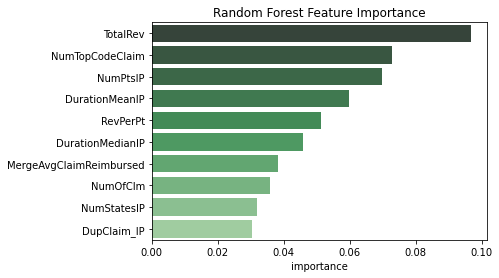

In [457]:
rf_feature_imp = pd.DataFrame(data = rf_final.feature_importances_, index=xtrain.columns, columns=['importance']).sort_values(by = 'importance', ascending=False)
# rf_feature_imp.plot(kind = 'bar')
rf_feature_imp.to_csv('../output/rf_final_features_importance.csv')
sns.barplot(y = rf_feature_imp.index[:10], x = 'importance', data = rf_feature_imp[:10],palette=sns.color_palette('Greens_d', n_colors=10))
plt.title('Random Forest Feature Importance')
plt.savefig('rf_final_feature_importance.png')

In [408]:
rf_grid_scores_test = rf_grid_scores[rf_grid_scores.columns[rf_grid_scores.columns.str.contains('test')]]
display(rf_grid_scores_test.head(2))
rf_grid_scores_train = rf_grid_scores[rf_grid_scores.columns[rf_grid_scores.columns.str.contains('train')]]
display(rf_grid_scores_train.head(2))

,mean_test_recall,mean_test_f1,mean_test_precision,mean_test_accuracy,mean_test_specificity,mean_test_roc_auc_score
0,0.612346,0.931115,0.644066,0.788583,0.964821,0.788583
1,0.681481,0.926713,0.581241,0.815250,0.949018,0.815250


,mean_train_recall,mean_train_f1,mean_train_precision,mean_train_accuracy,mean_train_specificity,mean_train_roc_auc_score
0,0.992593,0.987287,0.882605,0.989477,0.986362,0.989477
1,0.971605,0.971149,0.766082,0.970476,0.969347,0.970476


Text(0.5, 1.0, 'Random Forest Grid Search Model Scores: Test')

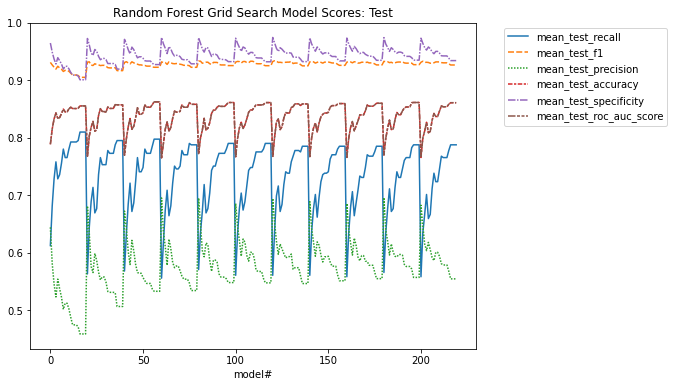

In [456]:
plt.figure(figsize=(8,6))
sns.lineplot(data =rf_grid_scores_test)
plt.legend(bbox_to_anchor=(1.05,1), loc=2)
# plt.xlim(0,20)
# plt.xticks(np.arange(0,21,1))
plt.xlabel('model#')
plt.title('Random Forest Grid Search Model Scores: Test')
# plt.savefig('../output/rf_gridsearch_scores_test3.png')
# plt.savefig('../output/rf_gridsearch_scores_test_full.png')

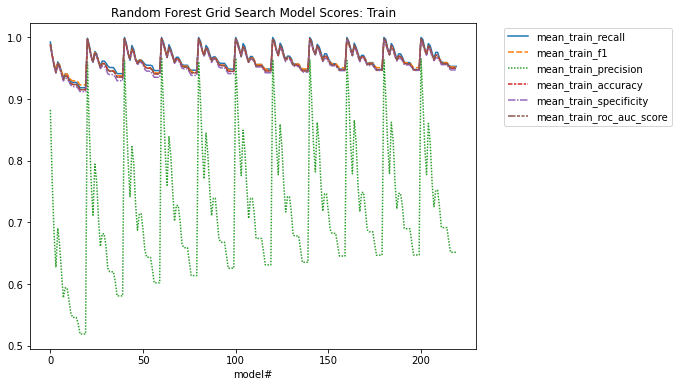

In [410]:
plt.figure(figsize=(8,6))
sns.lineplot(data =rf_grid_scores_train)
plt.legend(bbox_to_anchor=(1.05,1), loc=2)
plt.xlabel('model#')
plt.title('Random Forest Grid Search Model Scores: Train')
plt.savefig('../output/rf_gridsearch_scores_train2.png')
# plt.savefig('../output/rf_gridsearch_scores_train_full.png')

In [98]:
# second try
display(rf_grid.best_estimator_)
print('RF best validation score', rf_grid.best_score_)
print('RF best train score', rf_grid.score(xtrain, ytrain))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features=30,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=4, verbose=0,
                       warm_start=False)

RF best validation score 0.7589387536376049
RF best train score 0.8799832898638397


In [63]:
# first try
display(rf_grid.best_estimator_)
print('RF best validation score', rf_grid.best_score_)
print('RF best train score', rf_grid.score(xtrain, ytrain))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=30,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=4, verbose=0,
                       warm_start=False)

RF best validation score 0.9396950967173504
RF best train score 0.9743530499075785


#### finer gridsearch of random forest

In [473]:
max_features_2 = np.arange(1,math.sqrt(xtrain.shape[1]),1)
display(max_features_2)
min_leaf = np.arange(2, 9, 1)
display(min_leaf)
min_split = np.arange(6, 15, 1)
display(min_split)

array([1., 2., 3., 4., 5., 6.])

array([2, 3, 4, 5, 6, 7, 8])

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14])

In [ ]:
rf_params = [{'max_features': max_features_2,'n_estimators': [200, 500],
             'min_samples_split': min_split}] # 'min_samples_leaf': min_leaf,

kf5 = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

scores = { 'recall': make_scorer(recall_score, pos_label = 1, average = 'binary'), 
          'f1': make_scorer(f1_score, pos_label = 1, average = 'binary'),
         'precision': make_scorer(precision_score, pos_label = 1, average = 'binary'),
         'accuracy': make_scorer(accuracy_score), # use accuracy_score instead of balanced_accuracy_score
         'specificity': make_scorer(recall_score, pos_label = 0, average = 'binary'), 
         'roc_auc_score': make_scorer(roc_auc_score, average = 'binary')
         }


rf_grid_fine = GridSearchCV(estimator=rf, param_grid=rf_params, return_train_score=True, 
                       cv = kf5, verbose=2, scoring=scores, refit=False)

%time rf_grid_fine.fit(xtrain, ytrain)

Fitting 5 folds for each of 378 candidates, totalling 1890 fits
[CV] max_features=1.0, min_samples_leaf=2, min_samples_split=6, n_estimators=200 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=1.0, min_samples_leaf=2, min_samples_split=6, n_estimators=200, total=  11.4s
[CV] max_features=1.0, min_samples_leaf=2, min_samples_split=6, n_estimators=200 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.6s remaining:    0.0s


[CV]  max_features=1.0, min_samples_leaf=2, min_samples_split=6, n_estimators=200, total=  12.5s
[CV] max_features=1.0, min_samples_leaf=2, min_samples_split=6, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=2, min_samples_split=6, n_estimators=200, total=  15.2s
[CV] max_features=1.0, min_samples_leaf=2, min_samples_split=6, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=2, min_samples_split=6, n_estimators=200, total=  18.4s
[CV] max_features=1.0, min_samples_leaf=2, min_samples_split=6, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=2, min_samples_split=6, n_estimators=200, total=   9.9s
[CV] max_features=1.0, min_samples_leaf=2, min_samples_split=7, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=2, min_samples_split=7, n_estimators=200, total=   8.6s
[CV] max_features=1.0, min_samples_leaf=2, min_samples_split=7, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=2, min_samples_split=7, n_estimators=200, total=  15.4s
[CV] max

[CV]  max_features=1.0, min_samples_leaf=3, min_samples_split=6, n_estimators=200, total=   7.6s
[CV] max_features=1.0, min_samples_leaf=3, min_samples_split=6, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=3, min_samples_split=6, n_estimators=200, total=  12.1s
[CV] max_features=1.0, min_samples_leaf=3, min_samples_split=6, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=3, min_samples_split=6, n_estimators=200, total=   9.5s
[CV] max_features=1.0, min_samples_leaf=3, min_samples_split=7, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=3, min_samples_split=7, n_estimators=200, total=  11.8s
[CV] max_features=1.0, min_samples_leaf=3, min_samples_split=7, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=3, min_samples_split=7, n_estimators=200, total=  13.1s
[CV] max_features=1.0, min_samples_leaf=3, min_samples_split=7, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=3, min_samples_split=7, n_estimators=200, total=  11.0s
[CV] max

[CV]  max_features=1.0, min_samples_leaf=4, min_samples_split=6, n_estimators=200, total=   7.1s
[CV] max_features=1.0, min_samples_leaf=4, min_samples_split=6, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=4, min_samples_split=6, n_estimators=200, total=   7.8s
[CV] max_features=1.0, min_samples_leaf=4, min_samples_split=7, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=4, min_samples_split=7, n_estimators=200, total=   7.1s
[CV] max_features=1.0, min_samples_leaf=4, min_samples_split=7, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=4, min_samples_split=7, n_estimators=200, total=   8.6s
[CV] max_features=1.0, min_samples_leaf=4, min_samples_split=7, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=4, min_samples_split=7, n_estimators=200, total=  10.1s
[CV] max_features=1.0, min_samples_leaf=4, min_samples_split=7, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=4, min_samples_split=7, n_estimators=200, total=   9.7s
[CV] max

[CV]  max_features=1.0, min_samples_leaf=5, min_samples_split=6, n_estimators=200, total=   7.3s
[CV] max_features=1.0, min_samples_leaf=5, min_samples_split=7, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=5, min_samples_split=7, n_estimators=200, total=   7.2s
[CV] max_features=1.0, min_samples_leaf=5, min_samples_split=7, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=5, min_samples_split=7, n_estimators=200, total=   6.7s
[CV] max_features=1.0, min_samples_leaf=5, min_samples_split=7, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=5, min_samples_split=7, n_estimators=200, total=   8.9s
[CV] max_features=1.0, min_samples_leaf=5, min_samples_split=7, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=5, min_samples_split=7, n_estimators=200, total=   9.2s
[CV] max_features=1.0, min_samples_leaf=5, min_samples_split=7, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=5, min_samples_split=7, n_estimators=200, total=   9.8s
[CV] max

[CV]  max_features=1.0, min_samples_leaf=6, min_samples_split=7, n_estimators=200, total=   8.2s
[CV] max_features=1.0, min_samples_leaf=6, min_samples_split=7, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=6, min_samples_split=7, n_estimators=200, total=   8.6s
[CV] max_features=1.0, min_samples_leaf=6, min_samples_split=7, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=6, min_samples_split=7, n_estimators=200, total=   8.5s
[CV] max_features=1.0, min_samples_leaf=6, min_samples_split=7, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=6, min_samples_split=7, n_estimators=200, total=   9.6s
[CV] max_features=1.0, min_samples_leaf=6, min_samples_split=7, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=6, min_samples_split=7, n_estimators=200, total=   9.1s
[CV] max_features=1.0, min_samples_leaf=6, min_samples_split=8, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=6, min_samples_split=8, n_estimators=200, total=   8.1s
[CV] max

[CV]  max_features=1.0, min_samples_leaf=7, min_samples_split=7, n_estimators=200, total=   6.6s
[CV] max_features=1.0, min_samples_leaf=7, min_samples_split=7, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=7, min_samples_split=7, n_estimators=200, total=   6.6s
[CV] max_features=1.0, min_samples_leaf=7, min_samples_split=7, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=7, min_samples_split=7, n_estimators=200, total=   6.5s
[CV] max_features=1.0, min_samples_leaf=7, min_samples_split=7, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=7, min_samples_split=7, n_estimators=200, total=   7.4s
[CV] max_features=1.0, min_samples_leaf=7, min_samples_split=8, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=7, min_samples_split=8, n_estimators=200, total=   6.5s
[CV] max_features=1.0, min_samples_leaf=7, min_samples_split=8, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=7, min_samples_split=8, n_estimators=200, total=   6.5s
[CV] max

[CV]  max_features=1.0, min_samples_leaf=8, min_samples_split=7, n_estimators=200, total=   6.7s
[CV] max_features=1.0, min_samples_leaf=8, min_samples_split=7, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=8, min_samples_split=7, n_estimators=200, total=   7.0s
[CV] max_features=1.0, min_samples_leaf=8, min_samples_split=7, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=8, min_samples_split=7, n_estimators=200, total=   6.8s
[CV] max_features=1.0, min_samples_leaf=8, min_samples_split=8, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=8, min_samples_split=8, n_estimators=200, total=   8.9s
[CV] max_features=1.0, min_samples_leaf=8, min_samples_split=8, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=8, min_samples_split=8, n_estimators=200, total=   7.0s
[CV] max_features=1.0, min_samples_leaf=8, min_samples_split=8, n_estimators=200 
[CV]  max_features=1.0, min_samples_leaf=8, min_samples_split=8, n_estimators=200, total=   8.7s
[CV] max

In [ ]:
# sklearn.feature_selection import selectFromModel
# compute_class_weight

### K means clustering